## Experiment 03: A first look at MICAE predictions
Can we take 3 pretrained encoders, concatenate their latent spaces and connect those as input to a scaled-up decoder (*with input 3xlatent_dim*), by training the decoder on 3 concatenated input images which we seperately feed to the encoders? Is the prediction of that construct comparable in 'blurryness' to individual CAE predictions (00)? How does the loss of MICAE behave? Is it 3 times as large as compared to the CAE with same latent dimensions? Can we see signs of overfitting in this case?<br>
Results:
- Concatenation of encoder latent spaces and combination with scaled-up decoder works as expected.
- The training looks very similar to the CAE case. We start with lower loss value, most probably due to preloaded encoder weights.
- The training saturates after ~50 epochs. As in the of CAE training we do not see signs of overfitting.
- The validation loss and the difference val_loss-train_loss is very similar to the case of training a CAE with the same latent_dim (16).

In [11]:
import sys; sys.path.insert(0, '..')
import models
from keras.utils import plot_model
import dataset
import matplotlib.pyplot as plt
import random
import numpy as np
random.seed(1)

Let's train for 300 epochs and take a look at the loss progression.

In [2]:
n = 3
batch_size = 32
n_epochs = 300
latent_dim = 16

train_gen = dataset.BatchGenerator(dataset.x_train, n, batch_size)
test_gen = dataset.BatchGenerator(dataset.x_test, n, batch_size)

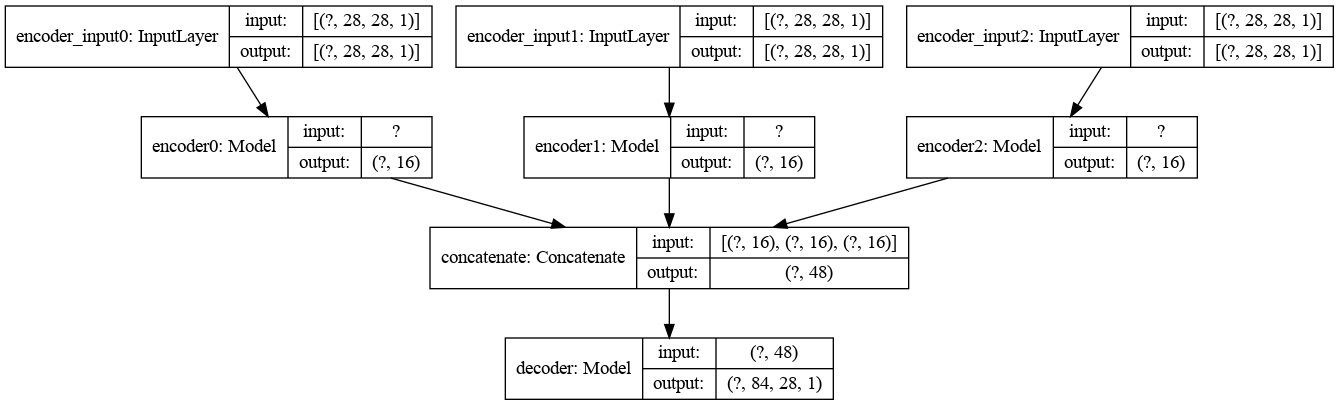

In [3]:
micae = models.build_MICAE(latent_dim, n)
micae.compile(loss='mse', optimizer='rmsprop')

plot_model(micae, expand_nested=False, show_shapes=True)

In [4]:
for i in range(n):
    encoder = micae.get_layer('encoder%d'%i)
    encoder.load_weights('../weights/CE16_epoch25_weights.h5')
    for layer in encoder.layers:
        layer.trainable = False
print(micae.summary())

Model: "MICAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input0 (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_input1 (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_input2 (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder0 (Model)                (None, 16)           69008       encoder_input0[0][0]             
______________________________________________________________________________________________

In [6]:
history = micae.fit(train_gen, validation_data=test_gen, epochs=n_epochs, verbose=True)

Epoch 1/300
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 2/300
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 3/300
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 4/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 6/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 7/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 8/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 9/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 10/300
1875/1875 [==============================]

In [7]:
micae.save('../models/micae_300epochs')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/micae_300epochs/assets


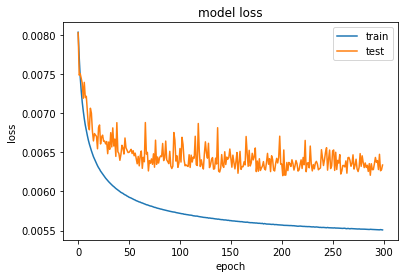

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

val_loss_100 0.006477193928972673
delta:  0.0006954681216446799


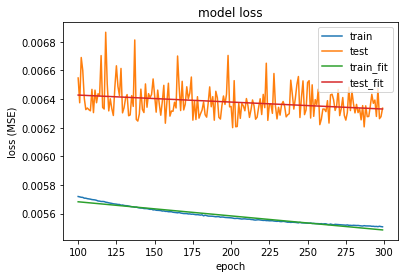

In [12]:
# linear fit

x_start, x_end = 100, 300
xs = np.array([i for i in range(x_start,x_end)])
ys = history.history['loss'][x_start:x_end]
test_ys = history.history['val_loss'][x_start:x_end]
test_fit = np.polyfit(xs, test_ys, 1)
train_fit = np.polyfit(xs, ys, 1)

plt.plot(xs, ys)
plt.plot(xs, test_ys)
plt.plot(xs, train_fit[0]*xs + train_fit[1])
plt.plot(xs, test_fit[0]*xs + test_fit[1])

print("val_loss_100", test_fit[1])
print("delta: ", test_fit[1] - train_fit[1])

plt.title('model loss')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train_fit', 'test_fit'], loc='upper right')

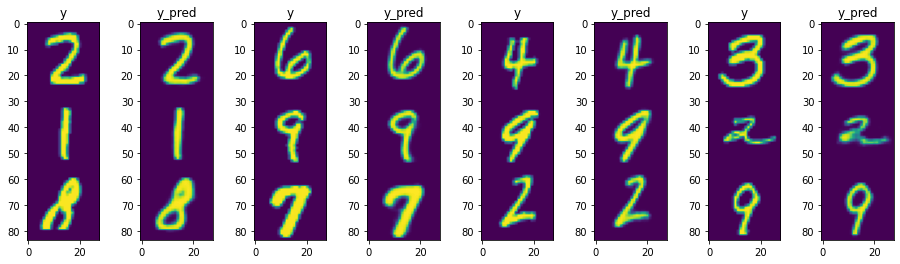

In [9]:
# Plot examples
plt.figure(figsize=(20,4))
a = 5
for (xs, ys), i in zip(test_gen, range(1,a)):
    ys_hat = micae.predict(xs)
    odd, even = (2*i)-1, 2*i
    ax = plt.subplot(1, a*2, odd)
    ax.set_title('y')
    plt.imshow(ys[i].reshape(n*28,28))
    ax = plt.subplot(1, a*2, even)
    ax.set_title('y_pred')
    plt.imshow(ys_hat[i].reshape(n*28,28))